In [1]:
#Upload libraries
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)
library(ggrepel)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
#Upload string#Upload data
host_data_comm_sia <- read_delim("host_data_comm_sia.tsv", 
                                 delim = "\t", escape_double = FALSE, 
                                 trim_ws = TRUE)
head(host_data_comm_sia)
colnames(host_data_comm_sia)

Rows: 3171 Columns: 29
── Column specification ──────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (17): Assembly Accession, Assembly BioSample Host, Tax name, Authority, ...
dbl (10): Organism Taxonomic ID, Taxid, Superkingdom taxid, Kingdom taxid, P...
lgl  (2): Curator common name, Scientific name is formal

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Assembly Accession,Assembly BioSample Host,Organism Taxonomic ID,Taxid,Tax name,Authority,Rank,Basionym,Basionym authority,Curator common name,⋯,Class taxid,Order name,Order taxid,Family name,Family taxid,Genus name,Genus taxid,Species name,Species taxid,Scientific name is formal
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,⋯,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<lgl>
GCF_000801145.1,NA,202947,202947,Actinobacillus equuli subsp. equuli,(van Straaten 1918) Haupt 1934,SUBSPECIES,NA,NA,NA,⋯,1236,Pasteurellales,135625,Pasteurellaceae,712,Actinobacillus,713,Actinobacillus equuli,718,TRUE
GCF_009676805.1,swine,202956,202956,Acinetobacter towneri,Carr et al. 2003,SPECIES,NA,NA,NA,⋯,1236,Moraxellales,2887326,Moraxellaceae,468,Acinetobacter,469,Acinetobacter towneri,202956,TRUE
GCF_016756395.1,NA,659352,659352,Actinacidiphila reveromycinica,Komaki et al. 2024,SPECIES,NA,NA,NA,⋯,1760,Kitasatosporales,85011,Streptomycetaceae,2062,Actinacidiphila,2995702,Actinacidiphila reveromycinica,659352,FALSE
GCF_019046965.1,missing,48296,48296,Acinetobacter pittii,Nemec et al. 2011,SPECIES,NA,NA,NA,⋯,1236,Moraxellales,2887326,Moraxellaceae,468,Acinetobacter,469,Acinetobacter pittii,48296,TRUE
GCF_022459075.1,Homo sapiens,470,470,Acinetobacter baumannii,Bouvet and Grimont 1986,SPECIES,NA,NA,NA,⋯,1236,Moraxellales,2887326,Moraxellaceae,468,Acinetobacter,469,Acinetobacter baumannii,470,TRUE
GCF_029582015.1,White Stork,470,470,Acinetobacter baumannii,Bouvet and Grimont 1986,SPECIES,NA,NA,NA,⋯,1236,Moraxellales,2887326,Moraxellaceae,468,Acinetobacter,469,Acinetobacter baumannii,470,TRUE


[1] "Assembly Accession"        "Assembly BioSample Host"  
 [3] "Organism Taxonomic ID"     "Taxid"                    
 [5] "Tax name"                  "Authority"                
 [7] "Rank"                      "Basionym"                 
 [9] "Basionym authority"        "Curator common name"      
[11] "Has type material"         "Group name"               
[13] "Superkingdom name"         "Superkingdom taxid"       
[15] "Kingdom name"              "Kingdom taxid"            
[17] "Phylum name"               "Phylum taxid"             
[19] "Class name"                "Class taxid"              
[21] "Order name"                "Order taxid"              
[23] "Family name"               "Family taxid"             
[25] "Genus name"                "Genus taxid"              
[27] "Species name"              "Species taxid"            
[29] "Scientific name is formal"

In [3]:
#select columms
host_data_comm_sia <- host_data_comm_sia%>%select(`Phylum name`, `Assembly BioSample Host`)

# remove NAs
host_data_comm_sia <- host_data_comm_sia%>%drop_na(`Assembly BioSample Host`)


#filtering dataset
host_data_comm_sia <- host_data_comm_sia %>%
  filter(!`Assembly BioSample Host` %in% c("missing", "Missing"))

In [4]:
#filtering swine data
host_data_comm_sia <- host_data_comm_sia %>%
  mutate(`Assembly BioSample Host` = if_else(
    str_detect(`Assembly BioSample Host`, fixed("pig", ignore_case = TRUE)) |
      str_detect(`Assembly BioSample Host`, fixed("swine", ignore_case = TRUE)) |
      str_detect(`Assembly BioSample Host`, fixed("Porcine", ignore_case = TRUE)) |
      str_detect(`Assembly BioSample Host`, fixed("Sus scrofa", ignore_case = TRUE)),
    "Swine",
    `Assembly BioSample Host`
  ))

#filtering bovine data
host_data_comm_sia <- host_data_comm_sia %>%
  mutate(`Assembly BioSample Host` = case_when(
    str_detect(`Assembly BioSample Host`, regex("Bos taurus|Cattle", ignore_case = TRUE)) ~ "Bovine",
    TRUE ~ `Assembly BioSample Host`
  ))

#filtering chicken data
host_data_comm_sia <- host_data_comm_sia %>%
  mutate(`Assembly BioSample Host` = case_when(
    str_detect(`Assembly BioSample Host`, regex("chicken", ignore_case = TRUE)) ~ "Gallus gallus",
    TRUE ~ `Assembly BioSample Host`
  ))

#remove unkown
host_data_comm_sia <- host_data_comm_sia %>%
  filter(!str_to_lower(str_trim(`Assembly BioSample Host`)) %in% 
           c("unknown", "not available", "not collected", "not applicable", "not available: not collected"))

In [5]:
#make pie data

host_data_comm_sia <- host_data_comm_sia %>%
  group_by(`Assembly BioSample Host`) %>%             # Group by 'region'
  mutate(host_count = n()) %>%   # Count occurrences and add to new column
  ungroup()                        # Remove grouping

host_final <- host_data_comm_sia%>%select(`Assembly BioSample Host`, 'host_count')

host_final_unique <- host_final %>%
  distinct(`Assembly BioSample Host`, .keep_all = TRUE)

host_final_unique <- host_final_unique %>%
  mutate(perc_host = host_count / sum(host_count) * 100) %>%
  filter(perc_host >= 0.5)

perc_host_round <-round(host_final_unique$perc_host, digits = 2)

In [6]:
library(RColorBrewer)

# Create and change color pallete
custom_colors <- brewer.pal(n = 9, name = "PuRd")
custom_colors[7] <- "#ff4d6d" # Substitui o tom mais escuro por um tom claro
custom_colors[8] <- "#CE1256"
custom_colors[9] <- "#980043"

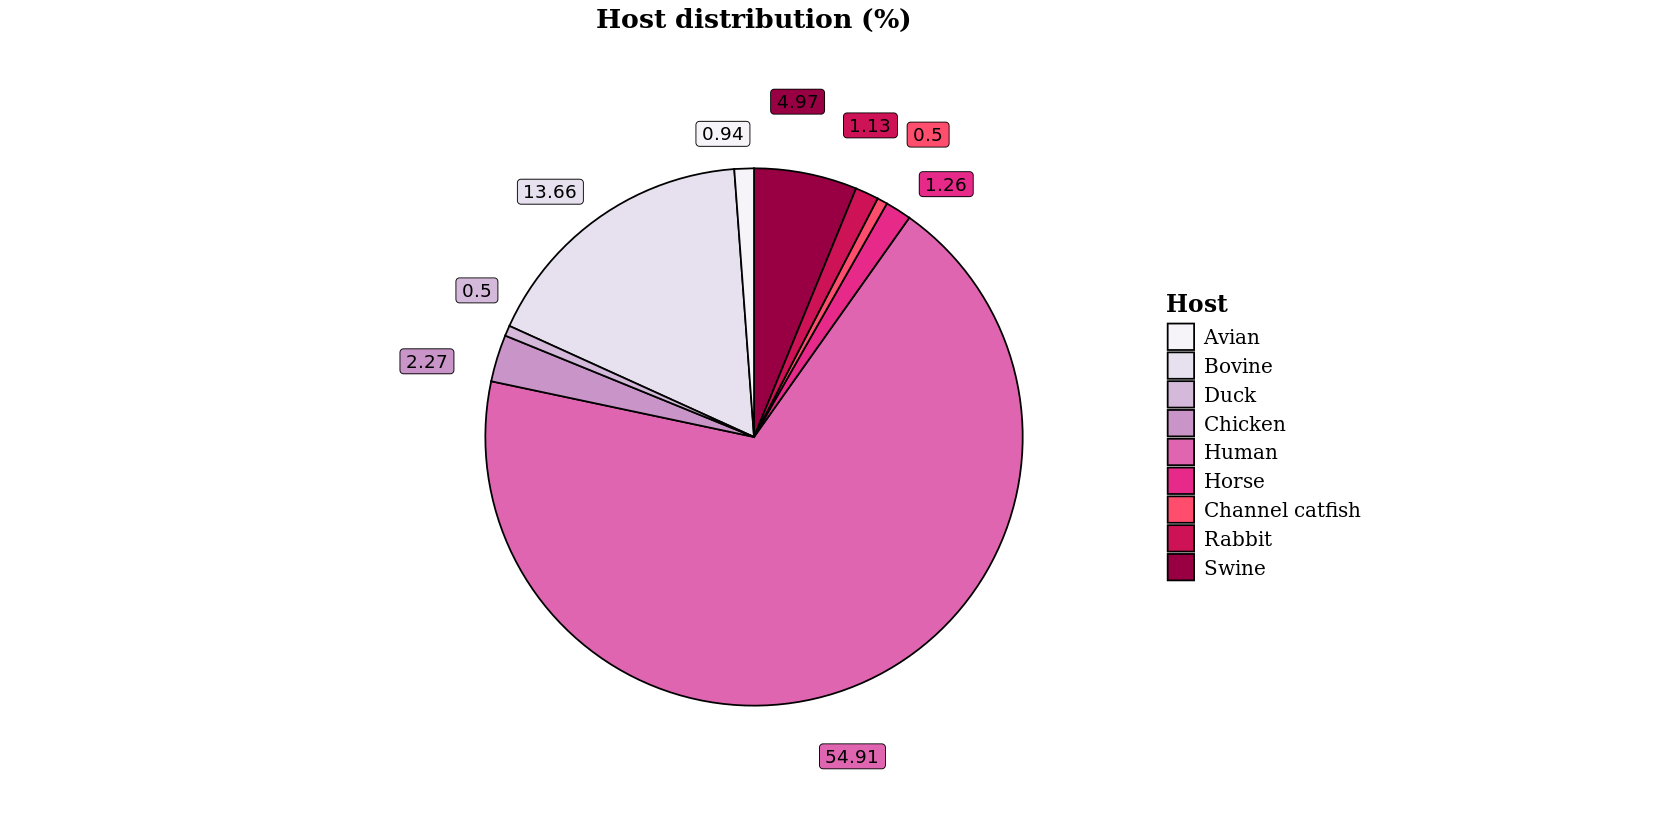

In [7]:
# Create a pie chart
host_graph <-ggplot(host_final_unique, aes(x = "", y = perc_host_round, fill = `Assembly BioSample Host`)) +
  geom_bar(stat = "identity", width = 1, color = "black") +
  coord_polar(theta = "y") +
  theme_void() + # Removes axes and background 
  theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold", family = "serif"),
        legend.text=element_text(size=12, family = "serif"),
        legend.title=element_text(size=14, face= "bold", family = "serif")) +
  labs(title = "Host distribution (%)", fill = "Host") +
  geom_label_repel(aes(x = 1.7, label = perc_host_round),
                   color = "black",
                   position = position_stack(vjust = 0.5),
                   show.legend = FALSE,
                   box.padding = 0.2) +
  scale_fill_manual(
    values = custom_colors,
    labels = c("Homo sapiens" = "Human", "horse" = "Horse", "Ictalurus punctatus" = "Channel catfish",
               "duck" = "Duck", "Gallus gallus" = "Chicken", "rabbit"= "Rabbit",
               "Swine" = "Swine", "Avian" = "Avian", "Bovine" = "Bovine") # Substitua os rótulos pelos desejados
  )

options(repr.plot.width = 14, repr.plot.height = 7)
print(host_graph)